<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch4_multilingual_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will explore how a single transformer model called XLM-RoBERTa (introduced in Chapter 3) can be fine-tuned to perform named entity recognition (NER) across several languages.


In [1]:
!pip install -qq transformers[sentencepiece] datasets

     |████████████████████████████████| 4.2 MB 32.8 MB/s 
     |████████████████████████████████| 346 kB 72.3 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 140 kB 80.6 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 63.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.1 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 127 kB 76.2 MB/s 
     |████████████████████████████████| 271 kB 76.9 MB/s 
     |████████████████████████████████| 144 kB 65.4 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 112 kB 61.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [15]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict,Counter 
from transformers import AutoTokenizer
import pandas as pd

For this case let’s assume that we want to perform NER for a customer based in
Switzerland, where there are four national languages (with English often serving as a
bridge between them). Let’s start by getting a suitable multilingual corpus for this
problem.

## Dataset

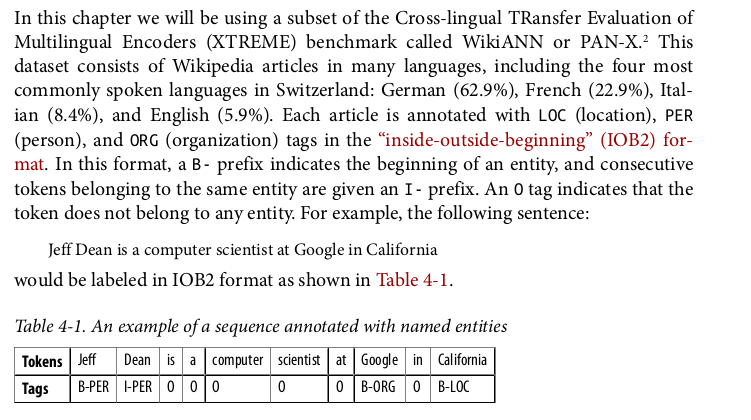

So, in order to create Swiss-like corpus we will sample diffenet language corpuses in the same ratio

In [3]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

In [4]:
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds: #train/validation/test
        panx_ch[lang][split] = (ds[split]
                                .shuffle(seed=0)
                                .select(range(int(frac * ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
              index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design we have more examples on German, so we will use it as starting point for the further zero-short learning for French, Italian and English.

In [6]:
# "de" sample example
element = panx_ch['de']['train'][0]
for key, value in element.items():
    print(f'{key}: {value}')

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
# And features are
for key, values in panx_ch['de']['train'].features.items():
    print(f'{key}: {values}')

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [10]:
panx_de = panx_ch['de'].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [11]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [12]:
# check sample
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


As a quick check that we don’t have any unusual imbalance in the tags, let’s calculate
the frequencies of each entity across each split:

In [16]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


Seems Ok.

## Multilingual Transformers

Our choice is XLM-RoBERTa

### Tokenization across different languages

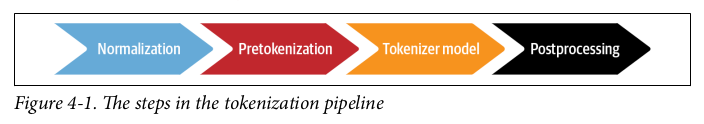

Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages. To get a feel for how SentencePiece compares to WordPiece, let’s load the BERT and XLM-R tokenizers in the
usual way with Transformers:

In [26]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

In [27]:
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [28]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


Here we see that instead of the `[CLS]` and `[SEP]` tokens that BERT uses for sentence classification tasks, XLM-R uses `<s>` and `<\s>` to denote the start and end of a sequence. These tokens are added in the final stage of tokenization, as we’ll see next.